# VARMALiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot, print_causal_directions, print_dagc

import warnings
warnings.filterwarnings('ignore')

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

['1.18.1', '0.25.3', '0.13.2', '1.2.0']


## Test data
We create test data consisting of 5 variables.

In [2]:
psi0 = np.array([
    [0, 0, -0.25, 0, 0],
    [-0.38, 0, 0.14, 0, 0],
    [0, 0, 0, 0, 0],
    [0.44, -0.2, -0.09, 0, 0],
    [0.07, -0.06, 0, 0.07, 0]
])
phi1 = np.array([
    [-0.04, -0.29, -0.26, 0.14, 0.47],
    [-0.42, 0.2, 0.1, 0.24, 0.25],
    [-0.25, 0.18, -0.06, 0.15, 0.18],
    [0.22, 0.39, 0.08, 0.12, -0.37],
    [-0.43, 0.09, -0.23, 0.16, 0.25]
])
theta1 = np.array([
    [ 0.15, -0.02, -0.3, -0.2, 0.21],
    [ 0.32, 0.12, -0.11, 0.03, 0.42],
    [-0.07, -0.5, 0.03, -0.27, -0.21],
    [-0.17, 0.35, 0.25, 0.24, -0.25],
    [0.09, 0.4, 0.41, 0.24, -0.31]
])
causal_order = [2, 0, 1, 3, 4]

# data generated from psi0 and phi1 and theta1, causal_order
X = np.loadtxt('data/sample_data_varma_lingam.csv', delimiter=',')

## Causal Discovery
To run causal discovery, we create a `VARMALiNGAM` object and call the `fit` method.

In [3]:
model = lingam.VARMALiNGAM(order=(1, 1), criterion=None)
model.fit(X)

Using the `causal_order_` properties, we can see the causal ordering as a result of the causal discovery.

In [4]:
model.causal_order_

[2, 0, 1, 3, 4]

Also, using the `adjacency_matrices_` properties, we can see the adjacency matrix as a result of the causal discovery.

In [5]:
# psi0
model.adjacency_matrices_[0][0]

array([[ 0.   ,  0.   , -0.238,  0.   ,  0.   ],
       [-0.392,  0.   ,  0.182,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ],
       [ 0.523, -0.149,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   ,  0.   ,  0.   ]])

In [6]:
# omega0
model.adjacency_matrices_[1][0]

array([[ 0.247, -0.12 , -0.128, -0.124,  0.037],
       [ 0.378,  0.319, -0.121, -0.024,  0.573],
       [-0.106, -0.624,  0.015, -0.302, -0.247],
       [-0.219,  0.261,  0.313,  0.228, -0.058],
       [ 0.256,  0.405,  0.411,  0.257, -0.287]])

We can draw a causal graph by utility funciton

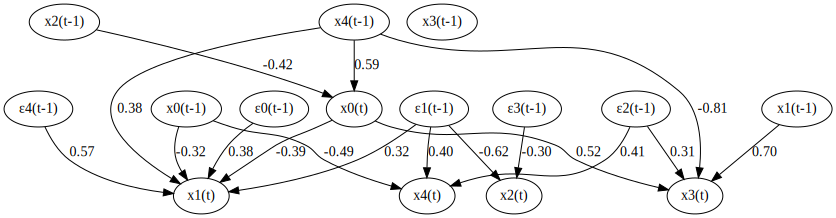

In [7]:
labels = ['x0(t)', 'x1(t)', 'x2(t)', 'x3(t)', 'x4(t)', 'x0(t-1)', 'x1(t-1)', 'x2(t-1)', 'x3(t-1)', 'x4(t-1)', 'ε0(t-1)', 'ε1(t-1)', 'ε2(t-1)', 'ε3(t-1)', 'ε4(t-1)']
make_dot(np.hstack([np.hstack(model.adjacency_matrices_[0]), np.hstack(model.adjacency_matrices_[1])]), lower_limit=0.3, ignore_shape=True, labels=labels)

## Bootstrap

### Bootstrapping
We call `bootstrap()` method instead of `fit()`. Here, the second argument specifies the number of bootstrap sampling.

In [8]:
model = lingam.VARMALiNGAM()
result = model.bootstrap(X, 100)

Since `BootstrapResult` object is returned, we can get the ranking of the causal directions extracted by `get_causal_direction_counts()` method. In the following sample code, `n_directions` option is limited to the causal directions of the top 8 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.4 or more.

In [9]:
cdc = result.get_causal_direction_counts(n_directions=8, min_causal_effect=0.4, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [10]:
print_causal_directions(cdc, 100, labels=labels)

x4(t) <--- x0(t-1) (b<0) (100.0%)
x0(t) <--- x2(t-1) (b<0) (99.0%)
x3(t) <--- x1(t-1) (b>0) (95.0%)
x0(t) <--- x4(t-1) (b>0) (75.0%)
x4(t) <--- x4(t-1) (b>0) (68.0%)
x3(t) <--- x2(t) (b<0) (51.0%)
x3(t) <--- x4(t-1) (b<0) (49.0%)
x2(t) <--- x1(t-1) (b>0) (22.0%)


Also, using the `get_directed_acyclic_graph_counts()` method, we can get the ranking of the DAGs extracted. In the following sample code, `n_dags` option is limited to the dags of the top 3 rankings, and `min_causal_effect` option is limited to causal directions with a coefficient of 0.3 or more.

In [11]:
dagc = result.get_directed_acyclic_graph_counts(n_dags=3, min_causal_effect=0.3, split_by_causal_effect_sign=True)

We can check the result by utility function.

In [12]:
print_dagc(dagc, 100, labels=labels)

DAG[0]: 4.0%
	x0(t) <--- x3(t) (b<0)
	x0(t) <--- x2(t-1) (b<0)
	x0(t) <--- x4(t-1) (b>0)
	x1(t) <--- x0(t-1) (b<0)
	x2(t) <--- x3(t) (b<0)
	x2(t) <--- x1(t-1) (b>0)
	x3(t) <--- x1(t-1) (b>0)
	x3(t) <--- x4(t-1) (b<0)
	x4(t) <--- x3(t) (b>0)
	x4(t) <--- x0(t-1) (b<0)
	x4(t) <--- x2(t-1) (b<0)
	x4(t) <--- x4(t-1) (b>0)
DAG[1]: 3.0%
	x0(t) <--- x1(t-1) (b<0)
	x0(t) <--- x2(t-1) (b<0)
	x0(t) <--- x4(t-1) (b>0)
	x1(t) <--- x0(t-1) (b<0)
	x2(t) <--- x1(t) (b<0)
	x2(t) <--- x3(t) (b<0)
	x2(t) <--- x0(t-1) (b<0)
	x2(t) <--- x1(t-1) (b>0)
	x3(t) <--- x0(t) (b<0)
	x3(t) <--- x1(t-1) (b>0)
	x3(t) <--- x4(t-1) (b<0)
	x4(t) <--- x3(t) (b>0)
	x4(t) <--- x0(t-1) (b<0)
	x4(t) <--- x2(t-1) (b<0)
	x4(t) <--- x4(t-1) (b>0)
DAG[2]: 3.0%
	x0(t) <--- x3(t) (b<0)
	x0(t) <--- x2(t-1) (b<0)
	x0(t) <--- x4(t-1) (b>0)
	x1(t) <--- x0(t-1) (b<0)
	x2(t) <--- x0(t-1) (b<0)
	x2(t) <--- x4(t-1) (b>0)
	x3(t) <--- x1(t) (b<0)
	x3(t) <--- x2(t) (b<0)
	x3(t) <--- x1(t-1) (b>0)
	x3(t) <--- x3(t-1) (b>0)
	x3(t) <--- x4(t-1)